# Assignment 5: Web Scraping and Big Data

## Part 1: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using BeautifulSoup to extract the relevant information from the HTML text. 

### Getting the HTML

First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. Here's a sample URL that is returned after manually typing in a search to Craigslist:

 http://philadelphia.craigslist.org/search/apa?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1

In [1]:
import requests

In [2]:
url_base = 'http://philadelphia.craigslist.org/search/apa'
params = {'bedrooms': 1}
rsp = requests.get(url_base, params=params)

In [3]:
# Note that requests automatically created the right URL
print(rsp.url)

https://philadelphia.craigslist.org/search/apa?bedrooms=1


## 1.1 Parse the HTML

- Use BeautifulSoup to parse the HTML response.
- Use your browser's Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML.

You should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [4]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(rsp.content, 'html.parser')
rows = soup.select('.result-row')

In [5]:
len(rows)

120

## 1.2 Find the relevant pieces of information

We will now focus on the first element in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms and square footage (this will be in a single element)
- The apartment title
- The datetime string of the posting, e.g., '2019-03-23 12:07'

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.

In [6]:
row = rows[0]
print(row.prettify())

<li class="result-row" data-pid="7006703801">
 <a class="result-image gallery" data-ids="1:00E0E_cGfaKraGQTs,1:00K0K_gDflA9UqxzF,1:00F0F_4k4pQpJbMUx,1:00606_eU83bjH8z9m,1:00D0D_asEaucVqKWf,1:00k0k_51pPb86HUQd" href="https://philadelphia.craigslist.org/apa/d/conshohocken-free-parking-trash-pickup/7006703801.html">
  <span class="result-price">
   $1420
  </span>
 </a>
 <p class="result-info">
  <span class="icon icon-star" role="button">
   <span class="screen-reader-text">
    favorite this post
   </span>
  </span>
  <time class="result-date" datetime="2019-10-31 03:34" title="Thu 31 Oct 03:34:52 AM">
   Oct 31
  </time>
  <a class="result-title hdrlnk" data-id="7006703801" href="https://philadelphia.craigslist.org/apa/d/conshohocken-free-parking-trash-pickup/7006703801.html">
   Free Parking, Trash Pickup, Upgraded Apartments
  </a>
  <span class="result-meta">
   <span class="result-price">
    $1420
   </span>
   <span class="housing">
    1br -
                    686ft
    <sup>


In [7]:
price = row.select_one('.result-price').text
housing = row.select_one('.housing').text
title = row.select_one('.result-title.hdrlnk').text
datetime = row.select_one('.result-date')['datetime']

In [8]:
print(price,housing,title,datetime)

$1420 
                    1br -
                    686ft2 -
                 Free Parking, Trash Pickup, Upgraded Apartments 2019-10-31 03:34


## 1.3 Functions to format the results 

In this section, you'll create two functions that take the price and time results from the last section and format them properly.

In [14]:
import re
from datetime import datetime

In [10]:
def format_size_and_bedrooms(size_string):
    """
    Extract size and number of bedrooms from the raw
    text, using regular expressions
    """
    split = re.findall("\n(.*?) -", size_string)
    
    # both size and bedrooms are listed
    if len(split) == 2:
        n_brs = split[0].strip().replace('br', '')
        this_size = split[1].strip().replace('ft2', '')
    # only bedrooms is listed
    elif 'br' in split[0]:
        n_brs = split[0].strip().replace('br', '')
        this_size = np.nan
    # only size is listed
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].strip().replace('ft2', '')
        n_brs = np.nan
    
    # return floats
    return float(this_size), float(n_brs)

In [11]:
def format_price(price_string):
    # Format the price string and return a float
    this_price = price_string.strip().replace('$', '')
    # This will involve using the string.strip() function to 
    # remove unwanted characters
    return float(this_price)

In [12]:
def format_time(date_string):
    # Return a Datetime object from the datetime string
    # Format: 2019-10-27 17:20
    return datetime.strptime(date_string,'%Y-%m-%d %H:%M')

## 1.4: Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 4 pages of search results and scrape data for about 500 apartments.

The outer for loop will loop over 4 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 480 apartment listings.

In [15]:
import numpy as np
import pandas as pd
from time import sleep

In [14]:
results = []

# search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5
results_per_page = 120
search_indices = np.arange(0, max_pages*results_per_page, results_per_page) 
url = 'http://philadelphia.craigslist.org/search/apa'

# loop over each page of search results
for i, s in enumerate(search_indices):
    print('Processing page %s...' % (i+1) )
    
    # get the response
    resp = requests.get(url, params={'bedrooms': 1, 's': s})
    
    # YOUR CODE: get the list of all aparements
    # This is the same code from Part 1.1
    # It should be a list of 120 apartments
    soup2 = BeautifulSoup(resp.content, 'html.parser')
    apts = soup2.select('.result-row')
    print("number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:
        
        # YOUR CODE: the bedrooms/size string
        sizes_brs = apt.select_one('.housing').text

        # YOUR CODE: the title string
        title = apt.select_one('.result-title.hdrlnk').text
        
        # YOUR CODE: the price string
        price = apt.select_one('.result-price').text

        # YOUR CODE: the time string
        dtime = apt.select_one('.result-date')['datetime']
      
        # format using functions from Part 1.3
        sizes, brs = format_size_and_bedrooms(sizes_brs)
        price = format_price(price)
        dtime = format_time(dtime)
        
        # save the result
        page_results.append([dtime, price, sizes, brs, title])
        
    
    # create a dataframe and save
    col_names = ['time', 'price', 'size', 'brs', 'title']
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)
    
    print("sleeping for 30 seconds between calls")
    sleep(30)
    
# Finally, concatenate all the results
results = pd.concat(results, axis=0)

Processing page 1...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 2...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 3...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 4...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 5...
number of apartments =  120
sleeping for 30 seconds between calls


In [15]:
results.head()

,time,price,size,brs,title
0,2019-10-31 03:34:00,1420.0,686.0,1.0,"Free Parking, Trash Pickup, Upgraded Apartments"
1,2019-10-31 03:33:00,1285.0,731.0,1.0,"Pet Friendly, Newly Renovated Kitchens, & Wash..."
2,2019-10-31 03:28:00,1430.0,NaN,1.0,Updated Old City Apartment with W/D and Parking
3,2019-10-31 03:28:00,1610.0,675.0,1.0,Just 1st month's rent and $500 security deposi...
4,2019-10-31 03:28:00,1695.0,670.0,1.0,2 Free Months and All utilities included on Ri...


## 1.5: Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Histogram for Apartment Prices')

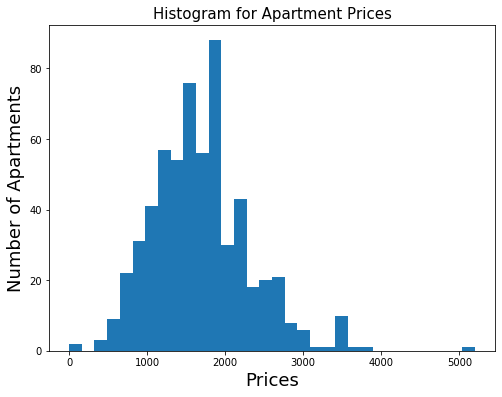

In [17]:
# Histogram for apartment prices
# Initialize
fig, ax = plt.subplots(figsize=(8,6))

# Plot a quick histogram
ax.hist(results['price'], bins='auto')

# Format
ax.set_xlabel("Prices", fontsize=18)
ax.set_ylabel("Number of Apartments", fontsize=18)
plt.title('Histogram for Apartment Prices', fontsize=15)

C:\Users\USER\.conda\envs\musa-620\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\USER\.conda\envs\musa-620\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\USER\.conda\envs\musa-620\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\USER\.conda\envs\musa-620\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Histogram for Apartment Prices per Square Foot')

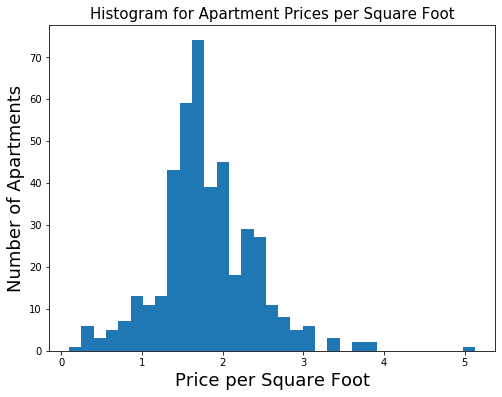

In [18]:
# Histogram for apartment price per square foot
results['price_unit'] = results['price'] / results['size']

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(results['price_unit'], bins='auto')

ax.set_xlabel("Price per Square Foot", fontsize=18)
ax.set_ylabel("Number of Apartments", fontsize=18)
plt.title('Histogram for Apartment Prices per Square Foot', fontsize=15)

## 1.6 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [19]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

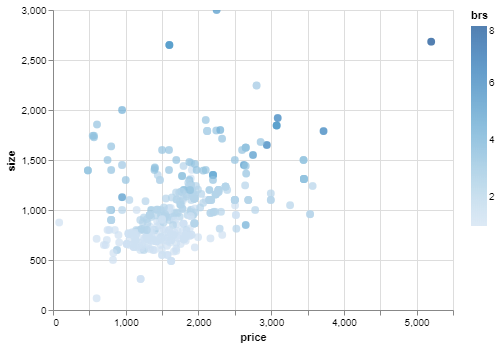

In [20]:
# initialize the chart with the data
chart = alt.Chart(results)

# define what kind of marks to use
chart = chart.mark_circle(size=60)

# encode the visual channels
chart = chart.encode(
    x="price",
    y="size",
    color="brs",
    tooltip=["title","price", "size", "brs", "time"],
)

# make the chart interactive
chart.interactive()

## Part 2: Making an animated map with Datashader

In this part, you will load a "large" data set of your choice and make an animated map of the data using datashader. 

There are several good options available from Open Data Philly, but you are welcome to choose a different source, as long it meets the requirements below.

#### Deliverable
Your final result should be a GIF animating changes in the data set in time. This GIF should be submitted to your repository, and the code used to produce the GIF should be in the notebook.

#### Notes
- For best results with datashader, the dataset should be at least 500,000 rows in size. If you are having difficulty finding a data set large enough, please email me.
- The data must have a date time column, so that you can animate the data in time.
- You can use either dask or pandas to load the data. If you're data set is approaching the size of your machine's memory, you will want to use dask.
- Recommendations from Open Data Philly include: 
    - [311 Requests](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
    - [Crime Incidents](https://www.opendataphilly.org/dataset/crime-incidents)
    - [L&I Code Violations](https://www.opendataphilly.org/dataset/licenses-and-inspections-violations)
    - [Parking Violations](https://www.opendataphilly.org/dataset/parking-violations)
    - [Real Estate Transfers](https://www.opendataphilly.org/dataset/real-estate-transfers)
- You can animate the data by the hour or by the year, e.g., parking violations by hour of day, or parking violations by year.

**Remember: when using datashader your data's coordinates should be in Web Mercator (EPSG coe 3857).**


In [2]:
import dask.dataframe as dd
import datashader as ds
import datashader.transfer_functions as tf

# Color map imports
from colorcet import fire

In [5]:
# Load a data frame directly with dask
df = dd.read_csv('C:/Users/USER/MUSA620/assignment-5-master/incidents_part1_part2.csv', assume_missing=True, dtype={'psa': 'object'})
df.head()

,the_geom,lng,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,the_geom_webmercator,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,hour_
0,0101000020E6100000F8EEE23F15CB52C0EE0F10A3D2F6...,-75.173172,340.0,1.0,1,2015-12-17 07:26:00,2015-12-17,07:26:00,0101000020110F0000C5A766CE1BEC5FC141FEBD3CBA85...,2.015011e+11,1800 BLOCK S CHADWICK ST,1400.0,Vandalism/Criminal Mischief,-75.173172,39.928303,39.928303,7.0
1,0101000020E61000007A4F69ED0BCB52C06E9C1C5786F6...,-75.172603,341.0,1.0,1,2015-12-17 11:04:00,2015-12-17,11:04:00,0101000020110F0000F89FBBF80BEC5FC1C77C11BD6585...,2.015011e+11,1500 BLOCK MC KEAN ST,1400.0,Vandalism/Criminal Mischief,-75.172603,39.925975,39.925975,11.0
2,0101000020E6100000D3C89D8834CB52C0D5E3A5381AF6...,-75.175081,342.0,1.0,1,2015-12-18 22:55:00,2015-12-18,22:55:00,0101000020110F0000A9DC08F250EC5FC160256000EE84...,2.015011e+11,2200 BLOCK S 17TH ST,1400.0,Vandalism/Criminal Mischief,-75.175081,39.922675,39.922675,22.0
3,0101000020E6100000E51F85042FCB52C058F92B853CF6...,-75.174745,343.0,1.0,1,2015-12-19 00:54:00,2015-12-19,00:54:00,0101000020110F00008468729347EC5FC1E25B43FC1385...,2.015011e+11,2200 BLOCK S 17TH ST,1400.0,Vandalism/Criminal Mischief,-75.174745,39.923722,39.923722,0.0
4,0101000020E61000007CD13F3D0DCB52C04961410E88F6...,-75.172683,344.0,1.0,1,2015-12-20 01:07:00,2015-12-20,01:07:00,0101000020110F00005BFA2F330EEC5FC18DA369A36785...,2.015011e+11,S 16TH ST / MC KEAN ST,1400.0,Vandalism/Criminal Mischief,-75.172683,39.926027,39.926027,1.0


In [6]:
# Remove rows with missing geometries
df = df.loc[df['point_x'].notnull()]

In [7]:
# Convert lat/lng to Web Mercator coordinates (x, y)
from datashader.utils import lnglat_to_meters
df['x'], df['y'] = lnglat_to_meters(df['point_x'], df['point_y'])
df.head()

,the_geom,lng,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,the_geom_webmercator,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,hour_,x,y
0,0101000020E6100000F8EEE23F15CB52C0EE0F10A3D2F6...,-75.173172,340.0,1.0,1,2015-12-17 07:26:00,2015-12-17,07:26:00,0101000020110F0000C5A766CE1BEC5FC141FEBD3CBA85...,2.015011e+11,1800 BLOCK S CHADWICK ST,1400.0,Vandalism/Criminal Mischief,-75.173172,39.928303,39.928303,7.0,-8.368239e+06,4.855529e+06
1,0101000020E61000007A4F69ED0BCB52C06E9C1C5786F6...,-75.172603,341.0,1.0,1,2015-12-17 11:04:00,2015-12-17,11:04:00,0101000020110F0000F89FBBF80BEC5FC1C77C11BD6585...,2.015011e+11,1500 BLOCK MC KEAN ST,1400.0,Vandalism/Criminal Mischief,-75.172603,39.925975,39.925975,11.0,-8.368176e+06,4.855191e+06
2,0101000020E6100000D3C89D8834CB52C0D5E3A5381AF6...,-75.175081,342.0,1.0,1,2015-12-18 22:55:00,2015-12-18,22:55:00,0101000020110F0000A9DC08F250EC5FC160256000EE84...,2.015011e+11,2200 BLOCK S 17TH ST,1400.0,Vandalism/Criminal Mischief,-75.175081,39.922675,39.922675,22.0,-8.368452e+06,4.854712e+06
3,0101000020E6100000E51F85042FCB52C058F92B853CF6...,-75.174745,343.0,1.0,1,2015-12-19 00:54:00,2015-12-19,00:54:00,0101000020110F00008468729347EC5FC1E25B43FC1385...,2.015011e+11,2200 BLOCK S 17TH ST,1400.0,Vandalism/Criminal Mischief,-75.174745,39.923722,39.923722,0.0,-8.368414e+06,4.854864e+06
4,0101000020E61000007CD13F3D0DCB52C04961410E88F6...,-75.172683,344.0,1.0,1,2015-12-20 01:07:00,2015-12-20,01:07:00,0101000020110F00005BFA2F330EEC5FC18DA369A36785...,2.015011e+11,S 16TH ST / MC KEAN ST,1400.0,Vandalism/Criminal Mischief,-75.172683,39.926027,39.926027,1.0,-8.368185e+06,4.855199e+06


In [8]:
# Get the x/y range for Philadelphia
Philly = (( -75.28,  -74.96), (39.86, 40.14))
x_range, y_range = lnglat_to_meters(Philly[0], Philly[1])
print(x_range, y_range)

[-8380131.26691764 -8344509.02986379] [4845618.66853859 4886307.60296654]


In [28]:
plot_width  = int(750)
plot_height = int(plot_width//1.2)

def create_image(df, x_range, y_range, w=plot_width, h=plot_height, cmap=fire):
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    # Aggregate the points of incidents
    agg = cvs.points(df, 'x', 'y', agg=ds.count())
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

def convert_to_12hour(hr24):
    from datetime import datetime
    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

def plot_dropoffs_by_hour(fig, data_all_hours, hour, x_range, y_range):
    # trim to the specific hour
    df_this_hour = data_all_hours.loc[data_all_hours["hour_"] == hour]
    # create the datashaded image
    img = create_image(df_this_hour, x_range, y_range)
    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.set_axis_off()
    # add a text label for the hour
    ax.text(
        0.05,
        0.9,
        convert_to_12hour(hour),
        color="white",
        fontsize=30,
        ha="left",
        transform=ax.transAxes,
    )
    # add title and my name
    ax.text(
        0.9,
        0.25,
        'Crimes',
        color="#E67E22",
        fontsize=25,
        ha="right",
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        0.2,
        'in Philadelphia',
        color="#E67E22",
        fontsize=25,
        ha="right",
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        0.15,
        'By Ann',
        color="white",
        fontsize=15,
        ha="right",
        transform=ax.transAxes,
    )   
    # draw the figure and return the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

In [30]:
import imageio

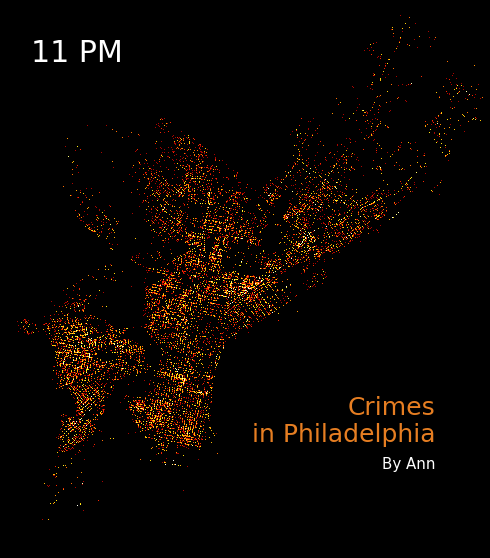

In [31]:
# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each hour
imgs = []
for hour in range(24):
    img = plot_dropoffs_by_hour(fig, df, hour, x_range=x_range, y_range=y_range)
    imgs.append(img)
    
# Combing the images for each hour into a single GIF
imageio.mimsave('crimes_name.gif', imgs, fps=1)